In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:80% !important;}
div.prompt {min-width:70px;}
div#toc-header{margin-top:150px;}
span.toc-item-num{display:none;}
div.CodeMirror {font-family:Consolas}
div.input {font-family:Consolas}
</style>
"""))

# import / GPU 메모리 정리

In [1]:
import pandas as pd 
import numpy as np
import os
import torch
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, AvgPool2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# GPU 메모리를 점진적으로 할당하도록 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
torch.cuda.empty_cache()  # GPU 메모리 정리

# 이미지, csv 불러오기 

In [4]:
# 데이터 불러오기
X = np.load('../team_project/data/data.npy')  # 이미지 데이터 (예: 80,000개)
y_df = pd.read_csv('../team_project/painting.csv')  # CSV 레이블 데이터

In [5]:
# y 라벨 인코딩 (문자형 → 숫자로 변환)
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y_df["genre"])  # 장르를 숫자로 변환

# y 원핫 인코딩 (Neural Network에서 학습 가능하도록 변환)
onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = onehot_encoder.fit_transform(y_labels.reshape(-1, 1))

C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
# 장르별 데이터 개수 확인
genre_counts = y_df["genre"].value_counts()
genre_ratios = genre_counts / genre_counts.sum()  # 장르별 비율 유지

In [7]:
# 각 장르에서 샘플링할 개수 설정
total_samples = 20000
samples_per_genre = (genre_ratios * total_samples).astype(int)
samples_per_genre[samples_per_genre == 0] = 2  # 최소 2개 이상 유지

In [8]:
# 샘플링 수행 (각 장르에서 비율 유지)
selected_indices = []

for genre, sample_count in samples_per_genre.items():
    genre_indices = y_df[y_df["genre"] == genre].index.tolist()  # 특정 장르의 인덱스 가져오기
    sampled_indices = np.random.choice(genre_indices, sample_count, replace=False)  # 랜덤 샘플링
    selected_indices.extend(sampled_indices)  # 최종 리스트에 추가

X_sample = X[selected_indices]  # 이미지 샘플링
y_sample = y_onehot[selected_indices]  # y 샘플링

print(f"X_sample.shape={X_sample.shape}, y_sample.shape={y_sample.shape}")

X_sample.shape=(19979, 128, 128, 3), y_sample.shape=(19979, 44)


In [9]:
# train-test 데이터 분할 (stratify=y_sample으로 클래스 균형 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.3, stratify=y_sample, shuffle=True)

print(f"X_train={X_train.shape}, X_test={X_test.shape}")

X_train=(13985, 128, 128, 3), X_test=(5994, 128, 128, 3)


In [10]:
# 학습 데이터 증강 설정
train_datagen = ImageDataGenerator(
    rotation_range=20,  # 0~20도 회전
    width_shift_range=0.1,  # 가로 이동 (최대 10%)
    height_shift_range=0.1,  # 세로 이동 (최대 10%)
    shear_range=0.2,  # 전단 변형
    zoom_range=0.2,  # 확대/축소 (20%)
    horizontal_flip=True,  # 좌우 반전
    fill_mode="nearest"  # 빈 픽셀을 가장 가까운 값으로 채움
)

# 증강된 학습 데이터 생성
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

# 검증 데이터는 증강 없이 사용
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(X_test, y_test, batch_size=64)

# CustomHistory class

In [11]:
class CustomHistory(Callback):  # on_epoch_end()는 각 에포크 종료시 자동 호출
    def __init__(self, times=5):  # 생성자 함수
        self.epoch = 0
        self.times = times
    def on_epoch_end(self, batch, 
                     logs={}):
        self.epoch += 1
        if self.epoch%self.times == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_acc:{}'.format(self.epoch, logs.get('loss'), logs.get('accuracy'), logs.get('val_loss'), logs.get('val_accuracy')))

# 1.LeNet

In [12]:
class LeNet:
    @staticmethod
    def build(input_shape=(128, 128, 3), num_classes=len(y_train[0]), activation='relu'):
        model = Sequential([
            Input(shape=input_shape),

            Conv2D(32, kernel_size=(5, 5), activation=activation, kernel_initializer=GlorotNormal(), padding='same'), # GlorotNormal() 가중치 초기화 
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Conv2D(64, kernel_size=(5, 5), activation=activation, kernel_initializer=GlorotNormal(), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Conv2D(128, kernel_size=(3, 3), activation=activation, kernel_initializer=GlorotNormal(), padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Flatten(),

            Dense(256, activation=activation, kernel_initializer=GlorotNormal()),
            BatchNormalization(),
            Dropout(0.4),

            Dense(128, activation=activation, kernel_initializer=GlorotNormal()),
            BatchNormalization(),
            Dropout(0.4),

            Dense(num_classes, activation='softmax')  # 최종 출력층
        ])
        return model

In [13]:
model = LeNet.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                        

In [14]:
# 학습설정
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy',
              metrics=['accuracy'])
# 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=30)
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[customHistory,
                                                                                             earlystopping], verbose=1)

Epoch 1/100
438/438 [==============================] - 48s 40ms/step - loss: 3.2955 - accuracy: 0.2566 - val_loss: 3.3678 - val_accuracy: 0.2858
Epoch 2/100
438/438 [==============================] - 15s 35ms/step - loss: 2.6634 - accuracy: 0.3281 - val_loss: 2.7462 - val_accuracy: 0.2491
Epoch 3/100
438/438 [==============================] - 15s 35ms/step - loss: 2.3803 - accuracy: 0.3601 - val_loss: 2.3493 - val_accuracy: 0.3509
Epoch 4/100
438/438 [==============================] - 15s 35ms/step - loss: 2.2014 - accuracy: 0.3888 - val_loss: 2.1895 - val_accuracy: 0.3787
Epoch 5/100
438/438 [==============================] - 15s 35ms/step - loss: 2.0857 - accuracy: 0.4129 - val_loss: 2.2929 - val_accuracy: 0.3722
Epoch 6/100
438/438 [==============================] - 15s 35ms/step - loss: 1.9728 - accuracy: 0.4342 - val_loss: 2.0904 - val_accuracy: 0.4042
Epoch 7/100
438/438 [==============================] - 15s 34ms/step - loss: 1.8140 - accuracy: 0.4767 - val_loss: 2.0672 - val_ac

In [17]:
# 모델평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}%'.format(accuracy*100))

188/188 [==============================] - 2s 9ms/step - loss: 4.1911 - accuracy: 0.3770
accuracy : 37.70%


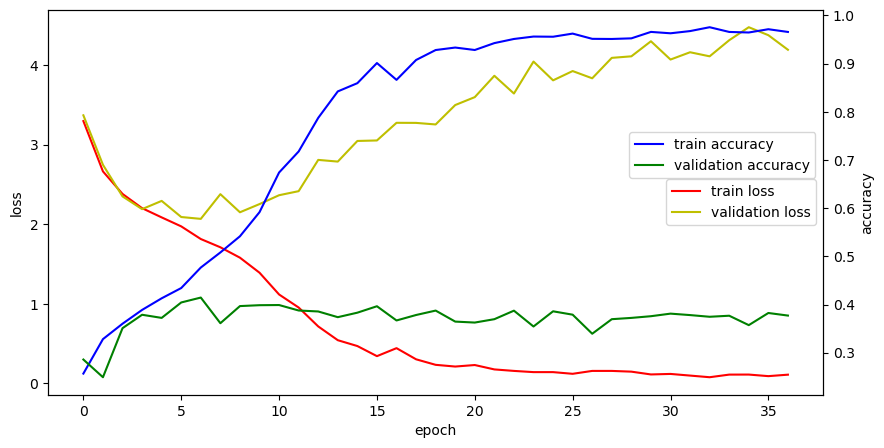

In [18]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [34]:
model.save("../team_project/data/cnn_lenet_model.h5")
print("모델 저장 완료")

모델 저장 완료


# 2.AlexNet

In [20]:
class AlexNet:
    @staticmethod
    def build(input_shape=(128,128,3), activation='relu', num_classes=len(y_train[0])):  
        model = Sequential([
            Input(shape=input_shape),

            Conv2D(32, kernel_size=(5,5), strides=(2,2), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            BatchNormalization(),

            Conv2D(64, kernel_size=(3,3), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),
            BatchNormalization(),

            Conv2D(128, kernel_size=(3,3), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(2,2), strides=(2,2)),

            Flatten(),

            Dense(512, activation=activation),
            Dropout(0.3),
            Dense(512, activation=activation),
            Dropout(0.3),

            Dense(num_classes, activation='softmax')
        ])
        return model

In [21]:
model = AlexNet.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                      

In [22]:
# 학습설정
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy',
              metrics=['accuracy'])
# 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=30)
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[customHistory,
                                                                                             earlystopping], verbose=1)

Epoch 1/100
438/438 [==============================] - 7s 13ms/step - loss: 2.6230 - accuracy: 0.2720 - val_loss: 2.5025 - val_accuracy: 0.2848
Epoch 2/100
438/438 [==============================] - 5s 12ms/step - loss: 2.4018 - accuracy: 0.3314 - val_loss: 2.3843 - val_accuracy: 0.2706
Epoch 3/100
438/438 [==============================] - 5s 12ms/step - loss: 2.2713 - accuracy: 0.3600 - val_loss: 2.3105 - val_accuracy: 0.3477
Epoch 4/100
438/438 [==============================] - 5s 12ms/step - loss: 2.1827 - accuracy: 0.3851 - val_loss: 2.5243 - val_accuracy: 0.3090
Epoch 5/100
438/438 [==============================] - 5s 12ms/step - loss: 2.0917 - accuracy: 0.4039 - val_loss: 2.2617 - val_accuracy: 0.3700
Epoch 6/100
438/438 [==============================] - 5s 12ms/step - loss: 2.0048 - accuracy: 0.4253 - val_loss: 2.0821 - val_accuracy: 0.4082
Epoch 7/100
438/438 [==============================] - 5s 12ms/step - loss: 1.9170 - accuracy: 0.4495 - val_loss: 2.0634 - val_accuracy:

In [23]:
# 모델평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}%'.format(accuracy*100))

188/188 [==============================] - 1s 4ms/step - loss: 4.0735 - accuracy: 0.4096
accuracy : 40.96%


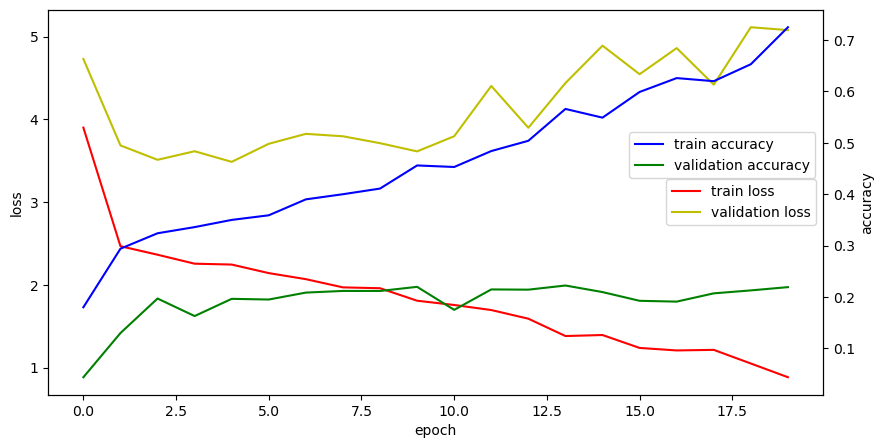

In [13]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [33]:
model.save("../team_project/data/cnn_alexnet_model.h5")
print("모델 저장 완료")

모델 저장 완료


# 3. VGGNet

In [12]:
class VGGNet:
    @staticmethod
    def build(input_shape=(128, 128, 3), num_classes=len(y_train[0])):
        model = Sequential()

        # Convolution Block 1
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Convolution Block 2
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Convolution Block 3
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # Fully Connected Layer
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

        return model

In [14]:
model = VGGNet.build(input_shape=(128, 128, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3

In [15]:
# 학습설정
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy',
              metrics=['accuracy'])
# 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=30)
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[customHistory,
                                                                                             earlystopping], verbose=1)

Epoch 1/100
438/438 [==============================] - 42s 63ms/step - loss: 3.4549 - accuracy: 0.2201 - val_loss: 2.7523 - val_accuracy: 0.2758
Epoch 2/100
438/438 [==============================] - 25s 58ms/step - loss: 2.8655 - accuracy: 0.2540 - val_loss: 2.8556 - val_accuracy: 0.2536
Epoch 3/100
438/438 [==============================] - 26s 59ms/step - loss: 2.7173 - accuracy: 0.2688 - val_loss: 2.5801 - val_accuracy: 0.2771
Epoch 4/100
438/438 [==============================] - 26s 59ms/step - loss: 2.6155 - accuracy: 0.2846 - val_loss: 2.4104 - val_accuracy: 0.3318
Epoch 5/100
438/438 [==============================] - 26s 60ms/step - loss: 2.5332 - accuracy: 0.2945 - val_loss: 2.4059 - val_accuracy: 0.3267
Epoch 6/100
438/438 [==============================] - 26s 59ms/step - loss: 2.4706 - accuracy: 0.3048 - val_loss: 2.3572 - val_accuracy: 0.3509
Epoch 7/100
438/438 [==============================] - 26s 60ms/step - loss: 2.4249 - accuracy: 0.3133 - val_loss: 2.3546 - val_ac

438/438 [==============================] - 26s 59ms/step - loss: 1.2910 - accuracy: 0.5762 - val_loss: 3.2221 - val_accuracy: 0.3824
Epoch 40/100
438/438 [==============================] - 26s 60ms/step - loss: 1.3027 - accuracy: 0.5745 - val_loss: 3.2233 - val_accuracy: 0.3846
Epoch 41/100
438/438 [==============================] - 26s 60ms/step - loss: 1.2869 - accuracy: 0.5824 - val_loss: 3.1709 - val_accuracy: 0.3769


In [16]:
# 모델평가
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}%'.format(accuracy*100))

188/188 [==============================] - 3s 15ms/step - loss: 3.1709 - accuracy: 0.3769
accuracy : 37.69%


In [ ]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [ ]:
model.save("../team_project/data/cnn_vggnet_model.h5")
print("모델 저장 완료")